# PsychExtract: OCR Feasibility Prototype

- Handwritten input
- Image preprocesssing
- OCR comparison
- Text post-processing
- Evaluation

# Install Packages


In [1]:
# install tesseract packages
!sudo apt-get update
!sudo apt-get install -y tesseract-ocr
!sudo apt-get install -y libtesseract-dev
!sudo apt-get install -y tesseract-ocr-eng

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,225 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe

In [2]:
# install easyocr
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 30.7 MB/s eta 0:00:00


In [3]:
!pip install paddlepaddle==3.2.2 -i https://www.paddlepaddle.org.cn/packages/stable/cpu/
!pip install "paddleocr[all]"

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cpu/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: opt_einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

In [4]:
# !pip install transformers accelerate torch torchvision pillow

In [5]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.8 MB/s eta 0:00:00


# Imports

In [6]:
# file management
import glob
import os
from google.colab import files
from pathlib import Path

# image processing
from PIL import Image, ImageOps
import cv2

# ocr
import easyocr
from paddleocr import PaddleOCR
from transformers import (TrOCRProcessor, VisionEncoderDecoderModel,
                          AutoProcessor, AutoModelForVision2Seq)
import torch

# text processing
import re
import string

# evaluation and comparison
import numpy as np
import pandas as pd
import jiwer
from jiwer import process_characters
import difflib
from collections import defaultdict
import matplotlib.pyplot as plt

Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


# Acquire sample and ground truth files

In [7]:
os.makedirs("sample_imgs", exist_ok=True)
# uplaod handwritten png/jpg files
uploaded = files.upload("sample_imgs")

Saving text0_a.png to sample_imgs/text0_a.png
Saving text0_b.png to sample_imgs/text0_b.png
Saving text0_c.png to sample_imgs/text0_c.png
Saving text1_a.png to sample_imgs/text1_a.png
Saving text1_b.png to sample_imgs/text1_b.png
Saving text1_c.png to sample_imgs/text1_c.png
Saving text2_a.png to sample_imgs/text2_a.png
Saving text2_b.png to sample_imgs/text2_b.png
Saving text2_c.png to sample_imgs/text2_c.png
Saving text3_a.png to sample_imgs/text3_a.png
Saving text3_b.png to sample_imgs/text3_b.png
Saving text3_c.png to sample_imgs/text3_c.png
Saving text4_a.png to sample_imgs/text4_a.png
Saving text4_b.png to sample_imgs/text4_b.png
Saving text4_c.png to sample_imgs/text4_c.png
Saving text5_a.png to sample_imgs/text5_a.png
Saving text5_b.png to sample_imgs/text5_b.png
Saving text5_c.png to sample_imgs/text5_c.png
Saving text6_a.png to sample_imgs/text6_a.png
Saving text6_b.png to sample_imgs/text6_b.png
Saving text6_c.png to sample_imgs/text6_c.png
Saving text7_a.png to sample_imgs/

In [8]:
os.makedirs("ground_truth_txt", exist_ok=True)
# upload groung truth txt files
uploaded = files.upload("ground_truth_txt")

Saving text0_a.txt to ground_truth_txt/text0_a.txt
Saving text0_b.txt to ground_truth_txt/text0_b.txt
Saving text0_c.txt to ground_truth_txt/text0_c.txt
Saving text1_a.txt to ground_truth_txt/text1_a.txt
Saving text1_b.txt to ground_truth_txt/text1_b.txt
Saving text1_c.txt to ground_truth_txt/text1_c.txt
Saving text2_a.txt to ground_truth_txt/text2_a.txt
Saving text2_b.txt to ground_truth_txt/text2_b.txt
Saving text2_c.txt to ground_truth_txt/text2_c.txt
Saving text3_a.txt to ground_truth_txt/text3_a.txt
Saving text3_b.txt to ground_truth_txt/text3_b.txt
Saving text3_c.txt to ground_truth_txt/text3_c.txt
Saving text4_a.txt to ground_truth_txt/text4_a.txt
Saving text4_b.txt to ground_truth_txt/text4_b.txt
Saving text4_c.txt to ground_truth_txt/text4_c.txt
Saving text5_a.txt to ground_truth_txt/text5_a.txt
Saving text5_b.txt to ground_truth_txt/text5_b.txt
Saving text5_c.txt to ground_truth_txt/text5_c.txt
Saving text6_a.txt to ground_truth_txt/text6_a.txt
Saving text6_b.txt to ground_tr

In [9]:
# grab all image files
raw_image_files = sorted(glob.glob("sample_imgs/*.png") +
                         glob.glob("sample_imgs/*.jpg"))
raw_image_files

['sample_imgs/text0_a.png',
 'sample_imgs/text0_b.png',
 'sample_imgs/text0_c.png',
 'sample_imgs/text1_a.png',
 'sample_imgs/text1_b.png',
 'sample_imgs/text1_c.png',
 'sample_imgs/text2_a.png',
 'sample_imgs/text2_b.png',
 'sample_imgs/text2_c.png',
 'sample_imgs/text3_a.png',
 'sample_imgs/text3_b.png',
 'sample_imgs/text3_c.png',
 'sample_imgs/text4_a.png',
 'sample_imgs/text4_b.png',
 'sample_imgs/text4_c.png',
 'sample_imgs/text5_a.png',
 'sample_imgs/text5_b.png',
 'sample_imgs/text5_c.png',
 'sample_imgs/text6_a.png',
 'sample_imgs/text6_b.png',
 'sample_imgs/text6_c.png',
 'sample_imgs/text7_a.png',
 'sample_imgs/text7_b.png',
 'sample_imgs/text7_c.png',
 'sample_imgs/text8_a.png',
 'sample_imgs/text8_b.png',
 'sample_imgs/text8_c.png',
 'sample_imgs/text9_a.png',
 'sample_imgs/text9_b.png',
 'sample_imgs/text9_c.png']

# Preprocess images

In [10]:
def preprocess_image(img_path: str, upscale=2.0) -> None:
  """
  Preprocess a single image by applying various image processing techniques.

  :param img_path: Path to the input image file.
  :type img_path: str
  :param upscale: Factor by which to upscale the image.
  :type upscale: float
  """
  img_path = Path(img_path)

  # load with PIL (format-agnostic)
  im = Image.open(img_path)
  # fix EXIF orientation
  im = ImageOps.exif_transpose(im)
  # convert to RGB
  im = im.convert("RGB")
  # convert to OpenCV format
  img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
  # apply grayscale ----
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # contrast enhancement (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(16, 16))
  gray = clahe.apply(gray)
  # adaptive threshold
  bw = cv2.adaptiveThreshold(
    gray,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    31,
    51)
  # upscale
  if upscale > 1:
    bw = cv2.resize(bw, None, fx=upscale, fy=upscale,
                    interpolation=cv2.INTER_CUBIC)

  # save as PNG with new name
  os.makedirs("preprocessed_imgs", exist_ok=True)
  output_name = f"preprocessed_imgs/{img_path.stem}_preprocessed.png"
  cv2.imwrite(str(output_name), bw)


In [11]:
def preprocess_images(image_paths: list) -> None:
  """
  Preprocess a list of images by applying various image processing techniques.

  :param image_paths: List of paths to the input image files.
  :type image_paths: list
  """
  for img_path in image_paths:
    preprocess_image(img_path)


In [12]:
def download_files(file_list: list) -> None:
  """
  Download files from the provided list.

  :param files: List of paths to the files to be downloaded.
  :type files: list
  """
  for f in file_list:
    files.download(f)

In [13]:
preprocess_images(raw_image_files)

In [14]:
image_files = sorted(glob.glob("preprocessed_imgs/*_preprocessed.png"))
image_files

['preprocessed_imgs/text0_a_preprocessed.png',
 'preprocessed_imgs/text0_b_preprocessed.png',
 'preprocessed_imgs/text0_c_preprocessed.png',
 'preprocessed_imgs/text1_a_preprocessed.png',
 'preprocessed_imgs/text1_b_preprocessed.png',
 'preprocessed_imgs/text1_c_preprocessed.png',
 'preprocessed_imgs/text2_a_preprocessed.png',
 'preprocessed_imgs/text2_b_preprocessed.png',
 'preprocessed_imgs/text2_c_preprocessed.png',
 'preprocessed_imgs/text3_a_preprocessed.png',
 'preprocessed_imgs/text3_b_preprocessed.png',
 'preprocessed_imgs/text3_c_preprocessed.png',
 'preprocessed_imgs/text4_a_preprocessed.png',
 'preprocessed_imgs/text4_b_preprocessed.png',
 'preprocessed_imgs/text4_c_preprocessed.png',
 'preprocessed_imgs/text5_a_preprocessed.png',
 'preprocessed_imgs/text5_b_preprocessed.png',
 'preprocessed_imgs/text5_c_preprocessed.png',
 'preprocessed_imgs/text6_a_preprocessed.png',
 'preprocessed_imgs/text6_b_preprocessed.png',
 'preprocessed_imgs/text6_c_preprocessed.png',
 'preprocesse

In [15]:
download_files(image_files[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
download_files(image_files[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
download_files(image_files[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Run OCR

In [2]:
def view_txts(files: list) -> None:
  """
  Print the contents of text files.

  :param files: List of paths to the text files.
  :type files: list
  """
  for txt in files:
    print(f"----{txt}----")
    print(open(txt).read() + "\n")

## Tesseract

In [19]:
def tesseract_ocr(image_files: list) -> None:
  """
  Perform OCR on a list of image files using Tesseract and save the results.

  :param image_files: List of paths to the input image files.
  :type image_files: list
  """
  os.makedirs("tess_detected", exist_ok=True)
  for img in image_files:
    print(f"Processing {img} with Tesseract")
    try:
      file_out = f"tess_detected/{os.path.splitext(img)[0].split("/")[1]}_tess_detected"
      !tesseract "{img}" "{file_out}" --oem 1 --psm 6 -l eng
      print(f"OCR complete for {img}. Result in {file_out}.txt\n")
    except Exception as e:
      print(f"Error processing {img}: {e}\n")

In [20]:
tesseract_ocr(image_files)

Processing preprocessed_imgs/text0_a_preprocessed.png with Tesseract
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
OCR complete for preprocessed_imgs/text0_a_preprocessed.png. Result in tess_detected/text0_a_preprocessed_tess_detected.txt

Processing preprocessed_imgs/text0_b_preprocessed.png with Tesseract
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
OCR complete for preprocessed_imgs/text0_b_preprocessed.png. Result in tess_detected/text0_b_preprocessed_tess_detected.txt

Processing preprocessed_imgs/text0_c_preprocessed.png with Tesseract
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
OCR complete for preprocessed_imgs/text0_c_preprocessed.png. Result in tess_detected/text0_c_preprocessed_tess_detected.txt

Processing preprocessed_imgs/text1_a_preprocessed.png with Tesseract
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
OCR complete for preprocessed_imgs/text1_a_preprocessed.png. Result in tess_detected/text1_a_preprocessed_tess_detected.txt

Proc

In [21]:
view_txts(glob.glob("tess_detected/*_tess_detected.txt"))

----tess_detected/text1_b_preprocessed_tess_detected.txt----
Vargruh how rease my body Falk thsmeraica . M
elves woe tune, | bo } ov vole (ro) clad
4 enien Ch


----tess_detected/text4_a_preprocessed_tess_detected.txt----
“There was ap wamert Tedat where 2 Felt ondn. JA didat Vast lang, Wot A ceminded me thet calm is HN -zissiele.


----tess_detected/text7_c_preprocessed_tess_detected.txt----
| noticed a pattern in my reactions today. | get defensive when | feel misunderstood.


----tess_detected/text7_a_preprocessed_tess_detected.txt----
L neticed a pattern @ my reactions ada. Le get Arkensive then 1 Feel wisendee steed,


----tess_detected/text9_b_preprocessed_tess_detected.txt----
Endan THE do with Wha hele round: helps ne
hese p cot Qa She S


----tess_detected/text9_c_preprocessed_tess_detected.txt----
Ending the d3y with writing feels grounding. It relps me make sense of everything that happened.


----tess_detected/text7_b_preprocessed_tess_detected.txt----
V noncel a patt

## EasyOCR

In [22]:
# set easyocr reader to english
easy_ocr = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [23]:
def easyocr_ocr(image_files: list, ocr_engine: easyocr.Reader) -> None:
  """
  Perform OCR on a list of image files using EasyOCR and save the results.

  :param image_files: List of paths to the input image files.
  :type image_files: list
  :param ocr_engine: An instance of the EasyOCR Reader.
  :type ocr_engine: easyocr.Reader
  """
  os.makedirs("easy_detected", exist_ok=True)
  for img in image_files:
    print(f"Processing {img} with EasyOCR")
    try:
      result = ocr_engine.readtext(f'{img}', detail=0, paragraph=True)
      file_out = f"easy_detected/{os.path.splitext(img)[0].split("/")[1]}_easy_detected.txt"
      with open(file_out, 'w') as f:
        f.write(" ".join(result))
      print(f"OCR complete for {img}. Result in {file_out}\n")
    except Exception as e:
      print(f"Error processing {img}: {e}\n")

In [24]:
easyocr_ocr(image_files, easy_ocr)

Processing preprocessed_imgs/text0_a_preprocessed.png with EasyOCR
OCR complete for preprocessed_imgs/text0_a_preprocessed.png. Result in easy_detected/text0_a_preprocessed_easy_detected.txt

Processing preprocessed_imgs/text0_b_preprocessed.png with EasyOCR
OCR complete for preprocessed_imgs/text0_b_preprocessed.png. Result in easy_detected/text0_b_preprocessed_easy_detected.txt

Processing preprocessed_imgs/text0_c_preprocessed.png with EasyOCR
OCR complete for preprocessed_imgs/text0_c_preprocessed.png. Result in easy_detected/text0_c_preprocessed_easy_detected.txt

Processing preprocessed_imgs/text1_a_preprocessed.png with EasyOCR
OCR complete for preprocessed_imgs/text1_a_preprocessed.png. Result in easy_detected/text1_a_preprocessed_easy_detected.txt

Processing preprocessed_imgs/text1_b_preprocessed.png with EasyOCR
OCR complete for preprocessed_imgs/text1_b_preprocessed.png. Result in easy_detected/text1_b_preprocessed_easy_detected.txt

Processing preprocessed_imgs/text1_c_pre

In [25]:
view_txts(glob.glob("easy_detected/*_easy_detected.txt"))

----easy_detected/text8_a_preprocessed_easy_detected.txt----
J lud + Alm< 1 K" suectling i ALere, 6 1 244 4u4c txplcn # Siue Gectiets

----easy_detected/text4_b_preprocessed_easy_detected.txt----
e kub 4 Mar€ny toxlux whr | &li Celn - Ir cdnk las} lona buh Ikremcedl & sl ccln j6 ~Il % Poss ke

----easy_detected/text8_c_preprocessed_easy_detected.txt----
hard to nare: | know something is there; but | cant quite expln it Some feelings &e

----easy_detected/text1_a_preprocessed_easy_detected.txt----
ud 1 rrugglcd X se -f trenthi & I Aced Lxd Kense mf 0ay fzh ti ~Cipd My salders Jtre *4bs,

----easy_detected/text5_a_preprocessed_easy_detected.txt----
1 keet ~lictig &bot tht ?est +d 4ux #:ffcreat 4Linys xitt bate been # 1 kad uede Mrler carc

----easy_detected/text5_b_preprocessed_easy_detected.txt----
leep Hinkicc Abur He Mer Onc ha~ dlle-tox #a 4 %yht hart been (hod Guckl mokr   chce

----easy_detected/text5_c_preprocessed_easy_detected.txt----
aJ how difftrcnt things mght hgve bcen #f I 

## PaddleOCR

In [26]:
paddle_ocr = PaddleOCR(
  use_doc_orientation_classify=False,
  use_doc_unwarping=False,
  use_textline_orientation=False)

/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-OCRv5_server_det`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to acce

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-OCRv5_server_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/84.4M [00:00<?, ?B/s]

In [27]:
def paddleocr_ocr(image_files: list, ocr_engine: PaddleOCR) -> None:
  """
  Perform OCR on a list of image files using PaddleOCR and save the results.

  :param image_files: List of paths to the input image files.
  :type image_files: list
  :param ocr_engine: An instance of the PaddleOCR engine.
  :type ocr_engine: PaddleOCR
  """
  os.makedirs("paddle_detected", exist_ok=True)
  for img in image_files:
    print(f"Processing {img} with PaddleOCR")
    try:
      result = ocr_engine.predict(input=img)
      output_file = f"paddle_detected/output/{os.path.splitext(img)[0].split("/")[1]}"
      result[0].save_to_img(output_file)
      result[0].save_to_json(output_file)
      file_out = f"paddle_detected/{os.path.splitext(img)[0].split("/")[1]}_paddle_detected.txt"
      with open(f"{file_out}", "w") as f:
        f.write(" ".join(result[0]['rec_texts']))
      print(f"OCR complete for {img}. Result in {file_out}\n")
    except Exception as e:
      print(f"Error processing {img}: {e}\n")

In [28]:
paddleocr_ocr(image_files, paddle_ocr)

Processing preprocessed_imgs/text0_a_preprocessed.png with PaddleOCR


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/PaddleX3.0/fonts/simfang.ttf ...
[==================================================] 100.00%


OCR complete for preprocessed_imgs/text0_a_preprocessed.png. Result in paddle_detected/text0_a_preprocessed_paddle_detected.txt

Processing preprocessed_imgs/text0_b_preprocessed.png with PaddleOCR
OCR complete for preprocessed_imgs/text0_b_preprocessed.png. Result in paddle_detected/text0_b_preprocessed_paddle_detected.txt

Processing preprocessed_imgs/text0_c_preprocessed.png with PaddleOCR
OCR complete for preprocessed_imgs/text0_c_preprocessed.png. Result in paddle_detected/text0_c_preprocessed_paddle_detected.txt

Processing preprocessed_imgs/text1_a_preprocessed.png with PaddleOCR
OCR complete for preprocessed_imgs/text1_a_preprocessed.png. Result in paddle_detected/text1_a_preprocessed_paddle_detected.txt

Processing preprocessed_imgs/text1_b_preprocessed.png with PaddleOCR
OCR complete for preprocessed_imgs/text1_b_preprocessed.png. Result in paddle_detected/text1_b_preprocessed_paddle_detected.txt

Processing preprocessed_imgs/text1_c_preprocessed.png with PaddleOCR
OCR comple

In [29]:
view_txts(glob.glob("paddle_detected/*.txt"))

----paddle_detected/text6_c_preprocessed_paddle_detected.txt----
Ifelt tired even after sleeingEmotionally ied is the only ayI can describe it.

----paddle_detected/text4_c_preprocessed_paddle_detected.txt----
There amomnttoy erftcm dt ast longbut it rmidd m ta misllos

----paddle_detected/text6_a_preprocessed_paddle_detected.txt----
1 fett tircd erces fer sleepiag Emtially drined is the ialf af I can descrie it.

----paddle_detected/text3_c_preprocessed_paddle_detected.txt----
Iflt frustrated di th ssiobutddt itout oudot ure  

----paddle_detected/text6_b_preprocessed_paddle_detected.txt----
I Fe ried e r siyEoially dris only woy I con descrbe tr

----paddle_detected/text1_a_preprocessed_paddle_detected.txt----
I ed          d  

----paddle_detected/text0_a_preprocessed_paddle_detected.txt----
Td e         

----paddle_detected/text2_c_preprocessed_paddle_detected.txt----
ritingtgfoth eisaofu

----paddle_detected/text5_c_preprocessed_paddle_detected.txt----
Ikee thinkinbout thest nd o

## TrOCR

In [30]:

trocr_processor = TrOCRProcessor.from_pretrained(
  "microsoft/trocr-base-handwritten"
)
trocr_model = VisionEncoderDecoderModel.from_pretrained(
  "microsoft/trocr-base-handwritten"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
trocr_model.to(device)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [31]:
def trocr_ocr(image_files: str,
              trocr_processor: TrOCRProcessor,
              trocr_model: VisionEncoderDecoderModel) -> None:
  """
  Perform OCR on a list of image files using TrOCR and save the results.

  :param image_files: Lisrt of paths to the input image files.
  :type image_files: str
  :param trocr_processor: An instance of the TrOCRProcessor.
  :type trocr_processor: TrOCRProcessor
  :param trocr_model: An instance of the VisionEncoderDecoderModel as the TrOCR model.
  :type trocr_model: VisionEncoderDecoderModel
  """
  os.makedirs("trocr_detected", exist_ok=True)
  for img in image_files:
    print(f"Processing {img} with TrOCR")
    try:
      image = Image.open(img).convert("RGB")
      pixel_values = (trocr_processor(images=image, return_tensors="pt")
                                     .pixel_values)
      pixel_values = pixel_values.to(device)

      generated_ids = trocr_model.generate(pixel_values)
      text = trocr_processor.batch_decode(generated_ids,
                                          skip_special_tokens=True)[0]
      file_out = f"trocr_detected/{os.path.splitext(img)[0].split("/")[1]}_trocr_detected.txt"
      with open(file_out, 'w') as f:
        f.write(text)
      print(f"OCR complete for {img}. Result in {file_out}\n")
    except Exception as e:
      print(f"Error processing {img}: {e}\n")


In [ ]:
trocr_ocr(image_files, trocr_processor, trocr_model)

Processing preprocessed_imgs/text0_a_preprocessed.png with TrOCR
OCR complete for preprocessed_imgs/text0_a_preprocessed.png. Result in trocr_detected/text0_a_preprocessed_trocr_detected.txt

Processing preprocessed_imgs/text0_b_preprocessed.png with TrOCR
OCR complete for preprocessed_imgs/text0_b_preprocessed.png. Result in trocr_detected/text0_b_preprocessed_trocr_detected.txt

Processing preprocessed_imgs/text0_c_preprocessed.png with TrOCR
OCR complete for preprocessed_imgs/text0_c_preprocessed.png. Result in trocr_detected/text0_c_preprocessed_trocr_detected.txt

Processing preprocessed_imgs/text1_a_preprocessed.png with TrOCR
OCR complete for preprocessed_imgs/text1_a_preprocessed.png. Result in trocr_detected/text1_a_preprocessed_trocr_detected.txt

Processing preprocessed_imgs/text1_b_preprocessed.png with TrOCR
OCR complete for preprocessed_imgs/text1_b_preprocessed.png. Result in trocr_detected/text1_b_preprocessed_trocr_detected.txt

Processing preprocessed_imgs/text1_c_pre

In [4]:
view_txts("trocr_detected/*_trocr_detected.txt")

----t----


FileNotFoundError: [Errno 2] No such file or directory: 't'

## Qwen2.5-VL

In [33]:
qwen_model_id = "Qwen/Qwen2.5-VL-7B-Instruct"

qwen_processor = AutoProcessor.from_pretrained(qwen_model_id)
qwen_model = AutoModelForVision2Seq.from_pretrained(
  qwen_model_id,
  torch_dtype=torch.float16,
  device_map="auto"
)

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

In [34]:
def qwenvl_ocr(image_files: list,
               qwen_processor: AutoProcessor,
               qwen_model: AutoModelForVision2Seq) -> None:
  """
  Perform OCR on a list of image files using Qwen-VL and save the results.

  :param image_files: List of paths to the input image files.
  :type image_files: list
  :param qwen_processor: An instance of the Qwen-VL processor.
  :type qwen_processor: AutoProcessor
  :param qwen_model: An instance of the Qwen-VL model.
  :type qwen_model: AutoModelForVision2Seq
  """
  os.makedirs("qwen_detected", exist_ok=True)

  for img_path in image_files:
    print(f"Processing {img_path} with Qwen2.5-VL")

    try:
      image = Image.open(img_path)

      prompt = (
        "Transcribe the handwritten text exactly as it appears. "
        "Output ONLY the transcription."
        "No explanations or role labels."
        "Do not correct spelling, grammar, or punctuation."
      )
      messages = [{
          "role": "user",
          "content": [
              {"type": "image"},
              {"type": "text", "text": prompt}
          ]
      }]
      text_input = qwen_processor.apply_chat_template(
        messages,
        add_generation_prompt=True
      )
      inputs = (qwen_processor(text=text_input, images=image, return_tensors="pt")
                              .to(qwen_model.device))
      output = qwen_model.generate(**inputs, max_new_tokens=512)
      raw_text = qwen_processor.batch_decode(output, skip_special_tokens=True)[0]
      # Remove role headers if present
      cleaned_text = raw_text.split("assistant")[-1].strip()

      base_name = os.path.splitext(os.path.basename(img_path))[0]
      file_out = f"qwen_detected/{base_name}_qwen_detected.txt"
      with open(file_out, "w", encoding="utf-8") as f:
        f.write(cleaned_text)
      print(f"OCR complete for {img_path}. Result in {file_out}\n")

    except Exception as e:
      print(f"Error processing {img_path}: {e}\n")


In [35]:
qwenvl_ocr(image_files, qwen_processor, qwen_model)

Processing preprocessed_imgs/text0_a_preprocessed.png with Qwen2.5-VL
OCR complete for preprocessed_imgs/text0_a_preprocessed.png. Result in qwen_detected/text0_a_preprocessed_qwen_detected.txt

Processing preprocessed_imgs/text0_b_preprocessed.png with Qwen2.5-VL
OCR complete for preprocessed_imgs/text0_b_preprocessed.png. Result in qwen_detected/text0_b_preprocessed_qwen_detected.txt

Processing preprocessed_imgs/text0_c_preprocessed.png with Qwen2.5-VL
OCR complete for preprocessed_imgs/text0_c_preprocessed.png. Result in qwen_detected/text0_c_preprocessed_qwen_detected.txt

Processing preprocessed_imgs/text1_a_preprocessed.png with Qwen2.5-VL
OCR complete for preprocessed_imgs/text1_a_preprocessed.png. Result in qwen_detected/text1_a_preprocessed_qwen_detected.txt

Processing preprocessed_imgs/text1_b_preprocessed.png with Qwen2.5-VL
OCR complete for preprocessed_imgs/text1_b_preprocessed.png. Result in qwen_detected/text1_b_preprocessed_qwen_detected.txt

Processing preprocessed_i

In [36]:
view_txts(glob.glob("qwen_detected/*.txt"))

----qwen_detected/text7_a_preprocessed_qwen_detected.txt----
I noticed a pattern in my reactions today. I get defensive when I feel misunderstood.

----qwen_detected/text8_b_preprocessed_qwen_detected.txt----
Some feelings are hard to name. I know something is there, but I can't quite explain it.

----qwen_detected/text5_b_preprocessed_qwen_detected.txt----
I keep thinking about the past and how different things might have been if I had made another choice

----qwen_detected/text4_c_preprocessed_qwen_detected.txt----
There was a moment today where I felt calm. It didn't last long, but it reminded me that calm is still possible.

----qwen_detected/text3_b_preprocessed_qwen_detected.txt----
I felt frustrated during the sessions, but I didn't say it out loud. I'm not sure why I held back.

----qwen_detected/text4_b_preprocessed_qwen_detected.txt----
There was a moment today when I felt calm. It didn't last long, but it reminded me that calm is still possible.

----qwen_detected/text6_b_pr

# OCR outputs comparison

In [37]:
def compare(ocr_model: str,
            comparison_pairs: list,
            sim_score_dict: dict) -> dict:
  """
  Compare OCR results with ground truth texts and update similarity scores.

  :param ocr_model: Name of the OCR model used.
  :type ocr_model: str
  :param comparison_pairs: List of tuples containing ground truth and predicted text file paths.
  :type comparison_pairs: list
  :param sim_score_dict: Dictionary to store similarity scores.
  :type sim_score_dict: dict
  :return: Updated similarity score dictionary.
  :rtype: dict
  """
  for ground_truth, detected in comparison_pairs:
    ground_truth_text = open(ground_truth).read()
    detected = open(detected).read()

    similarity = (difflib.SequenceMatcher(None, ground_truth_text, detected)
                         .ratio())

    # add new dictionary entry
    comparison_file = ground_truth.split('.')[0].split("/")[1]
    sim_score_table_row_id = f"{ocr_model} {comparison_file} similarity"
    sim_score_dict[sim_score_table_row_id] = f"{similarity:.3f}"
  return sim_score_dict

In [38]:
# compare OCR vs ground truth
ground_truth_txts = sorted(glob.glob("ground_truth_txt/*.txt"))
tess_detected_txts = sorted(glob.glob("tess_detected/*.txt"))
easy_detected_txts = sorted(glob.glob("easy_detected/*.txt"))
paddle_detected_txts = sorted(glob.glob("paddle_detected/*.txt"))
trocr_detected_txts = sorted(glob.glob("trocr_detected/*.txt"))
qwen_detected_txts = sorted(glob.glob("qwen_detected/*.txt"))

tess_pairs = list(zip(ground_truth_txts, tess_detected_txts))
easy_pairs = list(zip(ground_truth_txts, easy_detected_txts))
paddle_pairs = list(zip(ground_truth_txts, paddle_detected_txts))
trocr_pairs = list(zip(ground_truth_txts, trocr_detected_txts))
qwen_pairs = list(zip(ground_truth_txts, qwen_detected_txts))
similarities = {}


In [39]:
compare("tess raw", tess_pairs, similarities)
compare("easy raw", easy_pairs, similarities)
compare("paddle raw", paddle_pairs, similarities)
compare("trocr raw", trocr_pairs, similarities)
compare("qwen raw", qwen_pairs, similarities)
similarities

{'tess raw text0_a similarity': '0.675',
 'tess raw text0_b similarity': '0.321',
 'tess raw text0_c similarity': '0.948',
 'tess raw text1_a similarity': '0.630',
 'tess raw text1_b similarity': '0.423',
 'tess raw text1_c similarity': '0.922',
 'tess raw text2_a similarity': '0.709',
 'tess raw text2_b similarity': '0.571',
 'tess raw text2_c similarity': '0.902',
 'tess raw text3_a similarity': '0.595',
 'tess raw text3_b similarity': '0.452',
 'tess raw text3_c similarity': '0.922',
 'tess raw text4_a similarity': '0.714',
 'tess raw text4_b similarity': '0.394',
 'tess raw text4_c similarity': '0.956',
 'tess raw text5_a similarity': '0.716',
 'tess raw text5_b similarity': '0.394',
 'tess raw text5_c similarity': '0.971',
 'tess raw text6_a similarity': '0.737',
 'tess raw text6_b similarity': '0.641',
 'tess raw text6_c similarity': '0.955',
 'tess raw text7_a similarity': '0.760',
 'tess raw text7_b similarity': '0.450',
 'tess raw text7_c similarity': '0.953',
 'tess raw text8

# File download before processing text

In [40]:
download_files(tess_detected_txts[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
download_files(tess_detected_txts[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
download_files(tess_detected_txts[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
download_files(easy_detected_txts[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
download_files(easy_detected_txts[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
download_files(easy_detected_txts[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
download_files(paddle_detected_txts[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
download_files(paddle_detected_txts[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
download_files(paddle_detected_txts[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
download_files(trocr_detected_txts[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
download_files(trocr_detected_txts[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
download_files(trocr_detected_txts[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
download_files(qwen_detected_txts[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
download_files(qwen_detected_txts[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
download_files(qwen_detected_txts[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Postprocess text

In [55]:
def case_fold(text: str) -> str:
  """
  Lowertcase the text consistently.

  :param text: Input text string.
  :type text: str
  :return: Lowercased text string.
  :rtype: str
  """
  return text.lower()

In [56]:
def remove_punctuation(text: str) -> str:
  """
  Remove punctuation while keeping spaces.

  :param text: Input text string.
  :type text: str
  :return: Text string without punctuation.
  :rtype: str
  """
  # translate removes all characters in string.punctuation
  table = str.maketrans("", "", string.punctuation)
  text = text.translate(table)
  return re.sub(r"[“”‘’€]", "", text)

In [57]:
def normalize_whitespace(text: str) -> str:
  """
  Collapse multiple spaces/newlines into a single space.

  :param text: Input text string.
  :type text: str
  :return: Text string with normalized whitespace.
  :rtype: str
  """
  return re.sub(r"\s+", " ", text).strip()

In [58]:
def process_text(text: str) -> str:
  """Full processing pipeline:
  - Case fold
  - Remove punctuation
  - Normalize whitespaces."""
  text = case_fold(text)
  text = remove_punctuation(text)
  text = normalize_whitespace(text)
  return text

In [59]:
def process_texts(text_files: list) -> None:
  for text_file in text_files:
    text = open(text_file).read()
    text = process_text(text)
    out_file = f"{os.path.splitext(text_file)[0]}_processed.txt"
    with open(out_file, 'w') as f:
      f.write(text)

In [60]:
txts = (ground_truth_txts +
        tess_detected_txts +
        easy_detected_txts +
        paddle_detected_txts +
        trocr_detected_txts +
        qwen_detected_txts)

process_texts(txts)

In [61]:
processed_truths = sorted(glob.glob("ground_truth_txt/*_processed.txt"))
processed_tess_detecteds = sorted(glob.glob("tess_detected/*_processed.txt"))
processed_easy_detecteds = sorted(glob.glob("easy_detected/*_processed.txt"))
processed_paddle_detecteds = sorted(glob.glob("paddle_detected/*_processed.txt"))
processed_trocr_detecteds = sorted(glob.glob("trocr_detected/*_processed.txt"))
processed_qwen_detecteds = sorted(glob.glob("qwen_detected/*_processed.txt"))

## File download

In [62]:
download_files(processed_tess_detecteds[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
download_files(processed_tess_detecteds[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
download_files(processed_tess_detecteds[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
download_files(processed_easy_detecteds[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
download_files(processed_easy_detecteds[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
download_files(processed_easy_detecteds[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
download_files(processed_paddle_detecteds[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
download_files(processed_paddle_detecteds[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
download_files(processed_paddle_detecteds[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
download_files(processed_trocr_detecteds[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
download_files(processed_trocr_detecteds[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
download_files(processed_trocr_detecteds[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
download_files(processed_qwen_detecteds[:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
download_files(processed_qwen_detecteds[10:20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
download_files(processed_qwen_detecteds[20:30])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Compare processed texts

In [78]:
processed_tess_pairs = list(zip(processed_truths, processed_tess_detecteds))
processed_easy_pairs = list(zip(processed_truths, processed_easy_detecteds))
processed_paddle_pairs = list(zip(processed_truths, processed_paddle_detecteds))
processed_trocr_pairs = list(zip(processed_truths, processed_trocr_detecteds))
processed_qwen_pairs = list(zip(processed_truths, processed_qwen_detecteds))

In [79]:
compare("tess processed", processed_tess_pairs, similarities)
compare("easy processed", processed_easy_pairs, similarities)
compare("paddle processed", processed_paddle_pairs, similarities)
compare("trocr processed", processed_trocr_pairs, similarities)
compare("qwen processed", processed_qwen_pairs, similarities)
similarities

{'tess raw text0_a similarity': '0.675',
 'tess raw text0_b similarity': '0.321',
 'tess raw text0_c similarity': '0.948',
 'tess raw text1_a similarity': '0.630',
 'tess raw text1_b similarity': '0.423',
 'tess raw text1_c similarity': '0.922',
 'tess raw text2_a similarity': '0.709',
 'tess raw text2_b similarity': '0.571',
 'tess raw text2_c similarity': '0.902',
 'tess raw text3_a similarity': '0.595',
 'tess raw text3_b similarity': '0.452',
 'tess raw text3_c similarity': '0.922',
 'tess raw text4_a similarity': '0.714',
 'tess raw text4_b similarity': '0.394',
 'tess raw text4_c similarity': '0.956',
 'tess raw text5_a similarity': '0.716',
 'tess raw text5_b similarity': '0.394',
 'tess raw text5_c similarity': '0.971',
 'tess raw text6_a similarity': '0.737',
 'tess raw text6_b similarity': '0.641',
 'tess raw text6_c similarity': '0.955',
 'tess raw text7_a similarity': '0.760',
 'tess raw text7_b similarity': '0.450',
 'tess raw text7_c similarity': '0.953',
 'tess raw text8

# Evaluation

## Character Accuracy and WER


In [80]:
def character_accuracy(detected_file: str, truth_file: str) -> float:
  """
  Computes character-level accuracy of predicted and ground truth strings

  :param detected_file: Path to the predicted text file.
  :type detected_file: str
  :param truth_file: Path to the ground truth text file.
  :type truth_file: str
  :return: Character-level accuracy as a float between 0 and 1.
  :rtype: float
  """
  detected = open(detected_file).read()
  truth = open(truth_file).read()
  # Remove surrounding whitespace
  detected = detected.strip()
  truth = truth.strip()

  # Avoid division by zero
  if len(truth) == 0:
    return 0.0

  # Count matches
  matches = sum(p == t for p, t in list(zip(detected, truth)))
  # Account for length differences as errors
  total = max(len(detected), len(truth))
  return matches / total

In [81]:
def word_error_rate(detected_file: str, truth_file: str) -> float:
  """
  Compute WER using jiwer.

  :param detected_file: Path to the predicted text file.
  :type detected_file: str
  :param truth_file: Path to the ground truth text file.
  :type truth_file: str
  :return: Word Error Rate as a float.
  :rtype: float"""
  detected = open(detected_file).read()
  truth = open(truth_file).read()
  return jiwer.wer(truth, detected)

In [82]:
def evaluate_engine(detecteds: list, truths: list) -> dict:
  """
  Returns average and individual character accuracy and WER

  :param detecteds: List of paths to predicted text files.
  :type detecteds: list
  :param truths: List of paths to ground truth text files.
  :type truths: list
  :return: Dictionary with mean character accuracy, mean WER, and individual scores.
  :rtype: dict
  """
  char_accs = []
  wers = []

  for detected, truth in list(zip(detecteds, truths)):
    char_accs.append(round(character_accuracy(detected, truth), 3))
    wers.append(round(word_error_rate(detected, truth), 3))

  return {
    "char_accuracy_mean": round(np.mean(char_accs), 3),
    "wer_mean": round(np.mean(wers), 3),
    "char_accuracies": char_accs,
    "wers": wers
  }

In [83]:
tess_results = evaluate_engine(processed_tess_detecteds, processed_truths)
easy_results = evaluate_engine(processed_easy_detecteds, processed_truths)
paddle_results = evaluate_engine(processed_paddle_detecteds, processed_truths)
trocr_results = evaluate_engine(processed_trocr_detecteds, processed_truths)
qwen_results = evaluate_engine(processed_qwen_detecteds, processed_truths)


In [84]:
tess_results

{'char_accuracy_mean': np.float64(0.202),
 'wer_mean': np.float64(0.611),
 'char_accuracies': [0.082,
  0.066,
  0.238,
  0.387,
  0.057,
  0.038,
  0.036,
  0.071,
  0.723,
  0.098,
  0.054,
  0.478,
  0.324,
  0.056,
  0.306,
  0.11,
  0.04,
  0.08,
  0.093,
  0.163,
  0.047,
  0.253,
  0.096,
  0.072,
  0.321,
  0.095,
  0.381,
  0.234,
  0.074,
  0.979],
 'wers': [0.87,
  0.913,
  0.217,
  0.95,
  0.85,
  0.25,
  0.727,
  0.864,
  0.273,
  0.8,
  0.95,
  0.2,
  0.682,
  0.955,
  0.136,
  0.842,
  0.947,
  0.105,
  0.688,
  0.812,
  0.125,
  0.667,
  0.867,
  0.2,
  0.824,
  0.941,
  0.118,
  0.625,
  0.812,
  0.125]}

In [85]:
easy_results

{'char_accuracy_mean': np.float64(0.061),
 'wer_mean': np.float64(0.938),
 'char_accuracies': [0.041,
  0.139,
  0.025,
  0.066,
  0.057,
  0.038,
  0.054,
  0.116,
  0.089,
  0.043,
  0.022,
  0.12,
  0.083,
  0.046,
  0.028,
  0.11,
  0.02,
  0.04,
  0.093,
  0.023,
  0.012,
  0.048,
  0.0,
  0.024,
  0.071,
  0.012,
  0.083,
  0.053,
  0.053,
  0.223],
 'wers': [1.0,
  0.87,
  0.826,
  1.0,
  1.0,
  1.0,
  0.955,
  0.909,
  0.818,
  1.0,
  0.9,
  1.0,
  1.0,
  1.0,
  0.955,
  0.947,
  0.947,
  1.0,
  1.0,
  0.938,
  0.938,
  1.0,
  0.933,
  1.0,
  0.941,
  1.0,
  0.588,
  1.0,
  1.0,
  0.688]}

In [86]:
paddle_results

{'char_accuracy_mean': np.float64(0.084),
 'wer_mean': np.float64(0.852),
 'char_accuracies': [0.008,
  0.148,
  0.016,
  0.019,
  0.085,
  0.038,
  0.027,
  0.045,
  0.009,
  0.054,
  0.054,
  0.033,
  0.046,
  0.093,
  0.12,
  0.12,
  0.03,
  0.04,
  0.209,
  0.093,
  0.058,
  0.084,
  0.024,
  0.084,
  0.31,
  0.179,
  0.179,
  0.17,
  0.011,
  0.128],
 'wers': [1.0,
  0.826,
  1.0,
  0.95,
  0.7,
  0.95,
  1.0,
  0.727,
  1.0,
  0.9,
  0.75,
  0.95,
  0.818,
  0.773,
  0.909,
  0.842,
  0.789,
  1.0,
  0.688,
  0.812,
  0.438,
  0.867,
  1.0,
  0.933,
  0.588,
  0.824,
  0.824,
  0.938,
  1.0,
  0.75]}

In [87]:
trocr_results

{'char_accuracy_mean': np.float64(0.439),
 'wer_mean': np.float64(0.442),
 'char_accuracies': [0.287,
  0.0,
  0.377,
  0.075,
  0.009,
  1.0,
  0.732,
  0.049,
  0.902,
  0.424,
  0.043,
  0.065,
  0.213,
  0.046,
  0.787,
  0.03,
  0.03,
  1.0,
  0.93,
  0.174,
  1.0,
  0.488,
  0.036,
  1.0,
  0.988,
  0.071,
  1.0,
  0.394,
  0.011,
  1.0],
 'wers': [0.565,
  1.0,
  0.261,
  0.55,
  1.0,
  0.0,
  0.318,
  1.0,
  0.136,
  0.4,
  0.95,
  0.2,
  0.545,
  1.0,
  0.182,
  0.368,
  0.842,
  0.0,
  0.25,
  0.562,
  0.0,
  0.2,
  0.933,
  0.0,
  0.059,
  0.882,
  0.0,
  0.125,
  0.938,
  0.0]}

In [88]:
qwen_results

{'char_accuracy_mean': np.float64(0.928),
 'wer_mean': np.float64(0.011),
 'char_accuracies': [0.992,
  0.213,
  1.0,
  0.981,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.387,
  1.0,
  1.0,
  0.278,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'wers': [0.043,
  0.13,
  0.0,
  0.05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.05,
  0.0,
  0.0,
  0.045,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

In [ ]:
# complie character accuracy and WER results into a table
results_table = pd.DataFrame(
  index = ["Tesseract", "EasyOCR", "PaddleOCR", "TrOCR", "Qwen2.5-VL"],
  data = {
    "Mean Char Acc (%)": [
      tess_results["char_accuracy_mean"]  * 100,
      easy_results["char_accuracy_mean"] * 100,
      paddle_results["char_accuracy_mean"] * 100,
      trocr_results["char_accuracy_mean"] * 100,
      qwen_results["char_accuracy_mean"] * 100
    ],
    "Mean WER (%)": [
      tess_results["wer_mean"] * 100,
      easy_results["wer_mean"] * 100,
      paddle_results["wer_mean"] * 100,
      trocr_results["wer_mean"] * 100,
      qwen_results["wer_mean"] * 100
    ]
  }
)

In [90]:
results_table

,Mean Char Acc (%),Mean WER (%)
Tesseract,20.2,61.1
EasyOCR,6.1,93.8
PaddleOCR,8.4,85.2
Qwen2.5-VL,43.9,44.2
TrOCR,92.8,1.1


## Qualitative heatmap

In [91]:
all_models_samples = {
  "Tesseract": processed_tess_pairs,
  "EasyOCR": processed_easy_pairs,
  "PaddleOCR": processed_paddle_pairs,
  "TrOCR": processed_trocr_pairs,
  "Qwen2.5-VL": processed_qwen_pairs
}

In [92]:
def compute_char_error_rates(samples: dict, character_list: str, min_occurrences=10) -> dict:
  """
  Compute character error rates for a list of samples.

  :param samples: Dictionary of sample paths.
  :type samples: dict
  :param character_list: List of characters to consider for error rate calculation.
  :type character_list: str
  :param min_occurrences: Minimum number of occurrences for a character to be considered.
  :type min_occurrences: int
  """
  gt_counts = defaultdict(int)
  err_counts = defaultdict(int)

  for gt_path, det_path in samples:
    gt = open(gt_path).read()
    det = open(det_path).read()
    if not isinstance(gt, str) or not isinstance(det, str):
      continue
    result = process_characters(gt, det)

    for gt_chars, hyp_chars in list(zip(result.references, result.hypotheses)):
      for gt_char, hyp_char in zip(gt_chars, hyp_chars):
        if gt_char not in character_list:
          continue
        gt_counts[gt_char] += 1
        if gt_char != hyp_char:
          err_counts[gt_char] += 1

  return {
    c: err_counts[c] / gt_counts[c]
    for c in gt_counts
    if gt_counts[c] >= min_occurrences
  }

In [93]:
CHARACTERS = list(string.ascii_lowercase + string.digits + " ")

char_error_by_model = {
  model: compute_char_error_rates(samples, CHARACTERS)
  for model, samples in all_models_samples.items()
}
df = pd.DataFrame(char_error_by_model).fillna(0).sort_index()

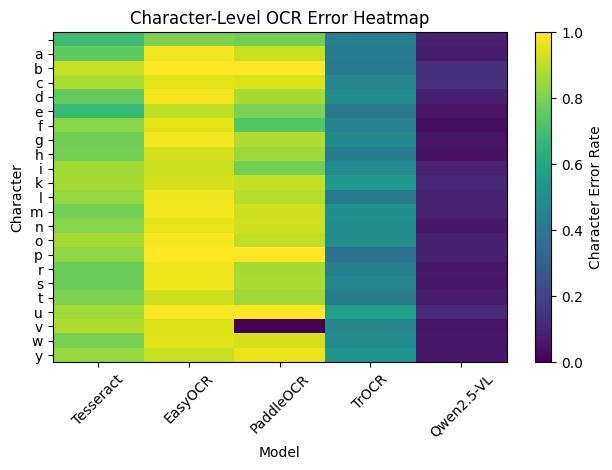

In [94]:
im = plt.imshow(df.values, aspect="auto", interpolation="nearest")
plt.colorbar(im, label="Character Error Rate")
plt.xticks(range(len(df.columns)), df.columns, rotation=45)
plt.yticks(range(len(df.index)), df.index)
plt.title("Character-Level OCR Error Heatmap")
plt.xlabel("Model")
plt.ylabel("Character")

plt.tight_layout()
plt.show()